# Baseline Results for Pain Intensity Estimation

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.utils import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset

In [2]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)

cnn_auc = []
rnn_auc = []

In [3]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight,verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

In [4]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [5]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(380, 1, 350, 35) (380, 3)
(235, 1, 350, 35) (235, 3)


In [6]:
classes = get_class_names('skeleton', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        219
Moderate    158
Severe        3
dtype: int64

In [7]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.578386605783866, 1: 0.8016877637130801, 2: 42.22222222222222}

### CNN + Bidirectional LSTM

Epoch 1/25
8/8 - 3s - loss: 53.0426 - accuracy: 0.4862 - auc: 0.6192 - precision: 0.4862 - recall: 0.4862 - f1_score: 0.3579 - val_loss: 3.9848 - val_accuracy: 0.4803 - val_auc: 0.6630 - val_precision: 0.4803 - val_recall: 0.4803 - val_f1_score: 0.2917 - 3s/epoch - 388ms/step
Epoch 2/25
8/8 - 1s - loss: 8.4994 - accuracy: 0.3439 - auc: 0.5095 - precision: 0.3400 - recall: 0.3360 - f1_score: 0.2722 - val_loss: 25.0938 - val_accuracy: 0.0157 - val_auc: 0.2546 - val_precision: 0.0157 - val_recall: 0.0157 - val_f1_score: 0.0178 - 507ms/epoch - 63ms/step
Epoch 3/25
8/8 - 0s - loss: 17.4760 - accuracy: 0.3123 - auc: 0.4785 - precision: 0.3123 - recall: 0.3123 - f1_score: 0.2043 - val_loss: 17.1166 - val_accuracy: 0.5512 - val_auc: 0.6634 - val_precision: 0.5512 - val_recall: 0.5512 - val_f1_score: 0.2369 - 459ms/epoch - 57ms/step
Epoch 4/25
8/8 - 0s - loss: 24.5479 - accuracy: 0.4664 - auc: 0.6259 - precision: 0.4664 - recall: 0.4664 - f1_score: 0.2899 - val_loss: 9.8662 - val_accuracy: 0.53

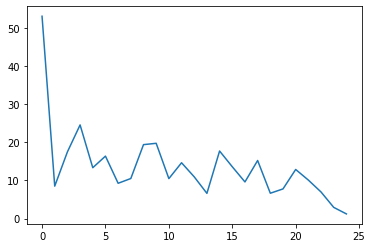

Epoch 1/25
8/8 - 3s - loss: 89.4681 - accuracy: 0.4269 - auc_1: 0.5689 - precision_1: 0.4269 - recall_1: 0.4269 - f1_score: 0.2721 - val_loss: 31.1606 - val_accuracy: 0.0472 - val_auc_1: 0.2716 - val_precision_1: 0.0472 - val_recall_1: 0.0472 - val_f1_score: 0.0442 - 3s/epoch - 378ms/step
Epoch 2/25
8/8 - 0s - loss: 14.1089 - accuracy: 0.3004 - auc_1: 0.4767 - precision_1: 0.2976 - recall_1: 0.2964 - f1_score: 0.2302 - val_loss: 7.9361 - val_accuracy: 0.2520 - val_auc_1: 0.3999 - val_precision_1: 0.2520 - val_recall_1: 0.2520 - val_f1_score: 0.1914 - 377ms/epoch - 47ms/step
Epoch 3/25
8/8 - 0s - loss: 3.6279 - accuracy: 0.4822 - auc_1: 0.6360 - precision_1: 0.4802 - recall_1: 0.4783 - f1_score: 0.3630 - val_loss: 5.3954 - val_accuracy: 0.5276 - val_auc_1: 0.6871 - val_precision_1: 0.5276 - val_recall_1: 0.5276 - val_f1_score: 0.3132 - 373ms/epoch - 47ms/step
Epoch 4/25
8/8 - 0s - loss: 15.2983 - accuracy: 0.3597 - auc_1: 0.5310 - precision_1: 0.3597 - recall_1: 0.3597 - f1_score: 0.242

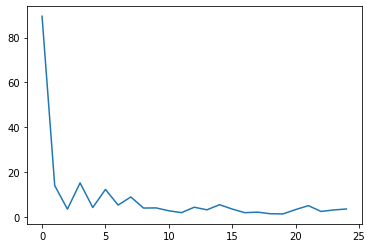

Epoch 1/25
8/8 - 3s - loss: 97.0360 - accuracy: 0.3780 - auc_2: 0.5293 - precision_2: 0.3780 - recall_2: 0.3780 - f1_score: 0.2690 - val_loss: 19.1645 - val_accuracy: 0.5952 - val_auc_2: 0.6964 - val_precision_2: 0.5952 - val_recall_2: 0.5952 - val_f1_score: 0.2488 - 3s/epoch - 341ms/step
Epoch 2/25
8/8 - 0s - loss: 16.2898 - accuracy: 0.4016 - auc_2: 0.5585 - precision_2: 0.4016 - recall_2: 0.4016 - f1_score: 0.2953 - val_loss: 19.9537 - val_accuracy: 0.0397 - val_auc_2: 0.2637 - val_precision_2: 0.0397 - val_recall_2: 0.0397 - val_f1_score: 0.0506 - 418ms/epoch - 52ms/step
Epoch 3/25
8/8 - 0s - loss: 11.8159 - accuracy: 0.3622 - auc_2: 0.5290 - precision_2: 0.3611 - recall_2: 0.3583 - f1_score: 0.2773 - val_loss: 8.5565 - val_accuracy: 0.3730 - val_auc_2: 0.4826 - val_precision_2: 0.3730 - val_recall_2: 0.3730 - val_f1_score: 0.2060 - 379ms/epoch - 47ms/step
Epoch 4/25
8/8 - 0s - loss: 6.9564 - accuracy: 0.2480 - auc_2: 0.4213 - precision_2: 0.2480 - recall_2: 0.2480 - f1_score: 0.21

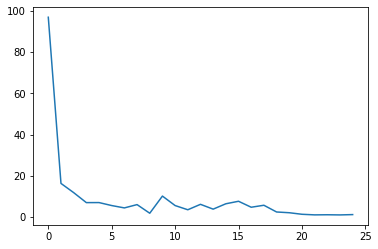

In [8]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on holdout set

In [9]:
y_pred = cnnlstm_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_body_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 22.13% 
Balanced Accuracy: 45.97% 
ROC/AUC: 0.50 
Precision: 0.22 
Recall: 0.22 
F1 score: 0.18


### RCNN

Epoch 1/25
8/8 - 2s - loss: 3.4826 - accuracy: 0.3320 - auc_3: 0.5304 - precision_3: 0.3238 - recall_3: 0.2688 - f1_score: 0.2594 - val_loss: 64.0480 - val_accuracy: 0.0000e+00 - val_auc_3: 0.2500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.0000e+00 - 2s/epoch - 220ms/step
Epoch 2/25
8/8 - 0s - loss: 2.2565 - accuracy: 0.2530 - auc_3: 0.4172 - precision_3: 0.2510 - recall_3: 0.2372 - f1_score: 0.1953 - val_loss: 18.0402 - val_accuracy: 0.1181 - val_auc_3: 0.3140 - val_precision_3: 0.1181 - val_recall_3: 0.1181 - val_f1_score: 0.1099 - 215ms/epoch - 27ms/step
Epoch 3/25
8/8 - 0s - loss: 1.2360 - accuracy: 0.4704 - auc_3: 0.6307 - precision_3: 0.4821 - recall_3: 0.4269 - f1_score: 0.3302 - val_loss: 6.7017 - val_accuracy: 0.4567 - val_auc_3: 0.6016 - val_precision_3: 0.4567 - val_recall_3: 0.4567 - val_f1_score: 0.2170 - 213ms/epoch - 27ms/step
Epoch 4/25
8/8 - 0s - loss: 1.4929 - accuracy: 0.5020 - auc_3: 0.7217 - precision_3: 0.4979 - recall_3: 0.4585 - f

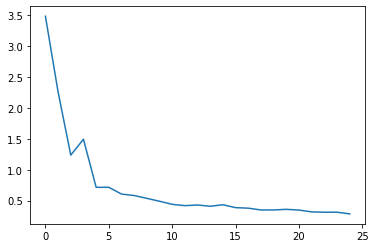

Epoch 1/25
8/8 - 1s - loss: 3.0430 - accuracy: 0.4585 - auc_4: 0.6962 - precision_4: 0.4619 - recall_4: 0.4308 - f1_score: 0.3164 - val_loss: 19.1810 - val_accuracy: 0.4016 - val_auc_4: 0.5512 - val_precision_4: 0.4016 - val_recall_4: 0.4016 - val_f1_score: 0.1910 - 1s/epoch - 179ms/step
Epoch 2/25
8/8 - 0s - loss: 0.8983 - accuracy: 0.5494 - auc_4: 0.7766 - precision_4: 0.5574 - recall_4: 0.5375 - f1_score: 0.3734 - val_loss: 3.4571 - val_accuracy: 0.5433 - val_auc_4: 0.7682 - val_precision_4: 0.5433 - val_recall_4: 0.5433 - val_f1_score: 0.3165 - 223ms/epoch - 28ms/step
Epoch 3/25
8/8 - 0s - loss: 1.1332 - accuracy: 0.4862 - auc_4: 0.7024 - precision_4: 0.4938 - recall_4: 0.4704 - f1_score: 0.3558 - val_loss: 4.8501 - val_accuracy: 0.5512 - val_auc_4: 0.7135 - val_precision_4: 0.5512 - val_recall_4: 0.5512 - val_f1_score: 0.2486 - 253ms/epoch - 32ms/step
Epoch 4/25
8/8 - 0s - loss: 0.7356 - accuracy: 0.5731 - auc_4: 0.7744 - precision_4: 0.5709 - recall_4: 0.5573 - f1_score: 0.4229 -

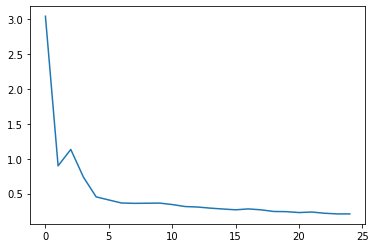

Epoch 1/25
8/8 - 1s - loss: 2.1859 - accuracy: 0.3701 - auc_5: 0.5885 - precision_5: 0.3877 - recall_5: 0.3465 - f1_score: 0.2803 - val_loss: 46.8086 - val_accuracy: 0.0079 - val_auc_5: 0.2540 - val_precision_5: 0.0079 - val_recall_5: 0.0079 - val_f1_score: 0.0052 - 1s/epoch - 176ms/step
Epoch 2/25
8/8 - 0s - loss: 1.4697 - accuracy: 0.3504 - auc_5: 0.5265 - precision_5: 0.3333 - recall_5: 0.3110 - f1_score: 0.2684 - val_loss: 9.0503 - val_accuracy: 0.5952 - val_auc_5: 0.6968 - val_precision_5: 0.5952 - val_recall_5: 0.5952 - val_f1_score: 0.2488 - 218ms/epoch - 27ms/step
Epoch 3/25
8/8 - 0s - loss: 0.6804 - accuracy: 0.5039 - auc_5: 0.7463 - precision_5: 0.5208 - recall_5: 0.4921 - f1_score: 0.4018 - val_loss: 2.3307 - val_accuracy: 0.4762 - val_auc_5: 0.6958 - val_precision_5: 0.4762 - val_recall_5: 0.4762 - val_f1_score: 0.3165 - 219ms/epoch - 27ms/step
Epoch 4/25
8/8 - 0s - loss: 1.0537 - accuracy: 0.5748 - auc_5: 0.8042 - precision_5: 0.5779 - recall_5: 0.5551 - f1_score: 0.3894 -

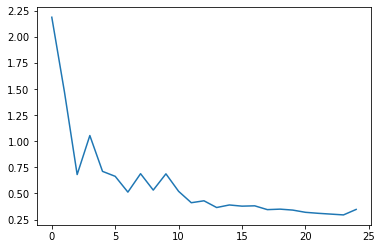

In [10]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [11]:
y_pred = rcnn_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_body_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 54.04% 
Balanced Accuracy: 31.93% 
ROC/AUC: 0.79 
Precision: 0.55 
Recall: 0.52 
F1 score: 0.31


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [12]:
X_train, X_test, y_train, y_test = load_dataset('AUs', level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 25) (366, 3)
(231, 1, 350, 25) (231, 3)


In [13]:
classes = get_class_names('AUs', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        211
Moderate    152
Severe        3
dtype: int64

In [14]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5781990521327014, 1: 0.8026315789473685, 2: 40.666666666666664}

### CNN + Bidirectional LSTM

Epoch 1/25
8/8 - 3s - loss: 22775.1191 - accuracy: 0.3238 - auc_6: 0.4938 - precision_6: 0.3238 - recall_6: 0.3238 - f1_score: 0.2630 - val_loss: 91.9995 - val_accuracy: 0.1311 - val_auc_6: 0.3447 - val_precision_6: 0.1311 - val_recall_6: 0.1311 - val_f1_score: 0.1199 - 3s/epoch - 371ms/step
Epoch 2/25
8/8 - 0s - loss: 27722.0137 - accuracy: 0.1066 - auc_6: 0.3180 - precision_6: 0.1066 - recall_6: 0.1066 - f1_score: 0.1107 - val_loss: 40083.8828 - val_accuracy: 0.4508 - val_auc_6: 0.5962 - val_precision_6: 0.4508 - val_recall_6: 0.4508 - val_f1_score: 0.2874 - 366ms/epoch - 46ms/step
Epoch 3/25
8/8 - 0s - loss: 23175.6055 - accuracy: 0.4959 - auc_6: 0.6262 - precision_6: 0.4959 - recall_6: 0.4959 - f1_score: 0.2860 - val_loss: 49.0282 - val_accuracy: 0.5410 - val_auc_6: 0.6557 - val_precision_6: 0.5410 - val_recall_6: 0.5410 - val_f1_score: 0.2340 - 367ms/epoch - 46ms/step
Epoch 4/25
8/8 - 0s - loss: 3136.6377 - accuracy: 0.5697 - auc_6: 0.6860 - precision_6: 0.5697 - recall_6: 0.5697 

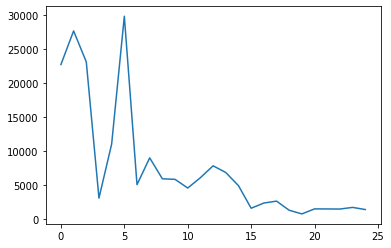

Epoch 1/25
8/8 - 3s - loss: 26566.6797 - accuracy: 0.4303 - auc_7: 0.5767 - precision_7: 0.4303 - recall_7: 0.4303 - f1_score: 0.2977 - val_loss: 32153.0312 - val_accuracy: 0.5984 - val_auc_7: 0.6988 - val_precision_7: 0.5984 - val_recall_7: 0.5984 - val_f1_score: 0.2496 - 3s/epoch - 340ms/step
Epoch 2/25
8/8 - 0s - loss: 26143.3438 - accuracy: 0.4754 - auc_7: 0.6043 - precision_7: 0.4754 - recall_7: 0.4754 - f1_score: 0.3174 - val_loss: 26742.7188 - val_accuracy: 0.5984 - val_auc_7: 0.6988 - val_precision_7: 0.5984 - val_recall_7: 0.5984 - val_f1_score: 0.2496 - 372ms/epoch - 46ms/step
Epoch 3/25
8/8 - 0s - loss: 45886.8828 - accuracy: 0.5656 - auc_7: 0.6742 - precision_7: 0.5656 - recall_7: 0.5656 - f1_score: 0.2408 - val_loss: 70056.0078 - val_accuracy: 0.5984 - val_auc_7: 0.6988 - val_precision_7: 0.5984 - val_recall_7: 0.5984 - val_f1_score: 0.2496 - 378ms/epoch - 47ms/step
Epoch 4/25
8/8 - 0s - loss: 25512.6387 - accuracy: 0.5656 - auc_7: 0.6742 - precision_7: 0.5656 - recall_7: 

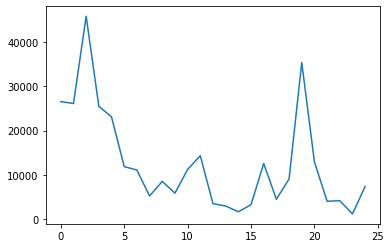

Epoch 1/25
8/8 - 3s - loss: 7984.5244 - accuracy: 0.4795 - auc_8: 0.6115 - precision_8: 0.4795 - recall_8: 0.4795 - f1_score: 0.3204 - val_loss: 24889.5527 - val_accuracy: 0.4426 - val_auc_8: 0.5820 - val_precision_8: 0.4426 - val_recall_8: 0.4426 - val_f1_score: 0.2401 - 3s/epoch - 344ms/step
Epoch 2/25
8/8 - 0s - loss: 24185.2441 - accuracy: 0.5041 - auc_8: 0.6271 - precision_8: 0.5041 - recall_8: 0.5041 - f1_score: 0.3004 - val_loss: 73050.9766 - val_accuracy: 0.5820 - val_auc_8: 0.6865 - val_precision_8: 0.5820 - val_recall_8: 0.5820 - val_f1_score: 0.2453 - 372ms/epoch - 46ms/step
Epoch 3/25
8/8 - 0s - loss: 9651.0908 - accuracy: 0.3320 - auc_8: 0.5034 - precision_8: 0.3320 - recall_8: 0.3320 - f1_score: 0.2018 - val_loss: 16827.5859 - val_accuracy: 0.1557 - val_auc_8: 0.3621 - val_precision_8: 0.1557 - val_recall_8: 0.1557 - val_f1_score: 0.1303 - 376ms/epoch - 47ms/step
Epoch 4/25
8/8 - 0s - loss: 10596.9990 - accuracy: 0.1189 - auc_8: 0.3377 - precision_8: 0.1189 - recall_8: 0.

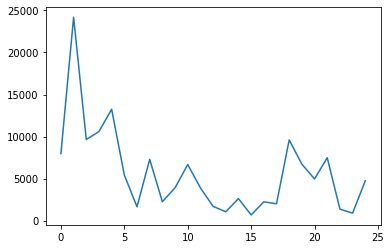

In [15]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [16]:
y_pred = cnnlstm_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 57.58% 
Balanced Accuracy: 30.74% 
ROC/AUC: 0.72 
Precision: 0.58 
Recall: 0.58 
F1 score: 0.31


### RCNN

Epoch 1/25
8/8 - 2s - loss: 1.6960 - accuracy: 0.0943 - auc_9: 0.3192 - precision_9: 0.0533 - recall_9: 0.0328 - f1_score: 0.0920 - val_loss: 1.7951 - val_accuracy: 0.0082 - val_auc_9: 0.2624 - val_precision_9: 0.1250 - val_recall_9: 0.0082 - val_f1_score: 0.0100 - 2s/epoch - 231ms/step
Epoch 2/25
8/8 - 0s - loss: 1.5415 - accuracy: 0.3443 - auc_9: 0.5774 - precision_9: 0.3483 - recall_9: 0.1270 - f1_score: 0.2354 - val_loss: 1.7877 - val_accuracy: 0.4836 - val_auc_9: 0.7021 - val_precision_9: 0.1250 - val_recall_9: 0.0082 - val_f1_score: 0.2173 - 200ms/epoch - 25ms/step
Epoch 3/25
8/8 - 0s - loss: 3.0988 - accuracy: 0.5902 - auc_9: 0.7479 - precision_9: 0.6009 - recall_9: 0.5492 - f1_score: 0.3066 - val_loss: 1.5317 - val_accuracy: 0.5000 - val_auc_9: 0.7259 - val_precision_9: 0.3750 - val_recall_9: 0.0246 - val_f1_score: 0.2222 - 204ms/epoch - 26ms/step
Epoch 4/25
8/8 - 0s - loss: 1.5963 - accuracy: 0.4303 - auc_9: 0.6049 - precision_9: 0.4490 - recall_9: 0.0902 - f1_score: 0.2845 - 

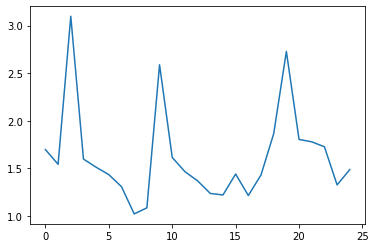

Epoch 1/25
8/8 - 1s - loss: 1.0584 - accuracy: 0.3975 - auc_10: 0.6059 - precision_10: 0.4286 - recall_10: 0.1967 - f1_score: 0.3067 - val_loss: 2.8515 - val_accuracy: 0.3852 - val_auc_10: 0.6743 - val_precision_10: 0.5000 - val_recall_10: 0.0164 - val_f1_score: 0.1991 - 1s/epoch - 175ms/step
Epoch 2/25
8/8 - 0s - loss: 4.2007 - accuracy: 0.4590 - auc_10: 0.7185 - precision_10: 0.4598 - recall_10: 0.4221 - f1_score: 0.2999 - val_loss: 1.3296 - val_accuracy: 0.3852 - val_auc_10: 0.6843 - val_precision_10: 0.5000 - val_recall_10: 0.0164 - val_f1_score: 0.1991 - 209ms/epoch - 26ms/step
Epoch 3/25
8/8 - 0s - loss: 0.9533 - accuracy: 0.5492 - auc_10: 0.7642 - precision_10: 0.5630 - recall_10: 0.2746 - f1_score: 0.3588 - val_loss: 0.9830 - val_accuracy: 0.5984 - val_auc_10: 0.7854 - val_precision_10: 0.5000 - val_recall_10: 0.0164 - val_f1_score: 0.2623 - 257ms/epoch - 32ms/step
Epoch 4/25
8/8 - 0s - loss: 0.7434 - accuracy: 0.5820 - auc_10: 0.7855 - precision_10: 0.6211 - recall_10: 0.4098 

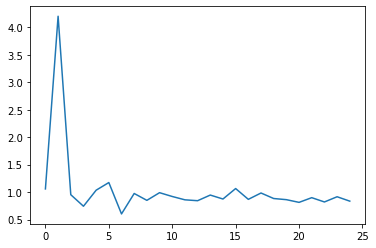

Epoch 1/25
8/8 - 1s - loss: 1.5288 - accuracy: 0.2459 - auc_11: 0.4422 - precision_11: 0.3390 - recall_11: 0.1639 - f1_score: 0.2040 - val_loss: 2.1886 - val_accuracy: 0.0328 - val_auc_11: 0.3299 - val_precision_11: 0.6000 - val_recall_11: 0.0246 - val_f1_score: 0.0316 - 1s/epoch - 175ms/step
Epoch 2/25
8/8 - 0s - loss: 7.4034 - accuracy: 0.3525 - auc_11: 0.5704 - precision_11: 0.4706 - recall_11: 0.2623 - f1_score: 0.2178 - val_loss: 1.8275 - val_accuracy: 0.5820 - val_auc_11: 0.5979 - val_precision_11: 0.4000 - val_recall_11: 0.0164 - val_f1_score: 0.2681 - 203ms/epoch - 25ms/step
Epoch 3/25
8/8 - 0s - loss: 1.7243 - accuracy: 0.5246 - auc_11: 0.6151 - precision_11: 0.4444 - recall_11: 0.1311 - f1_score: 0.2579 - val_loss: 3.1802 - val_accuracy: 0.4016 - val_auc_11: 0.6971 - val_precision_11: 0.4000 - val_recall_11: 0.0164 - val_f1_score: 0.1910 - 210ms/epoch - 26ms/step
Epoch 4/25
8/8 - 0s - loss: 1.2241 - accuracy: 0.4467 - auc_11: 0.5611 - precision_11: 0.6667 - recall_11: 0.0328 

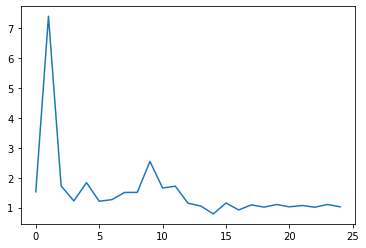

In [17]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [18]:
y_pred = rcnn_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 3.46% 
Balanced Accuracy: 34.43% 
ROC/AUC: 0.16 
Precision: 1.00 
Recall: 0.03 
F1 score: 0.03


## 3. Multimodal Early Fusion

### Dataset

In [19]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 60) (366, 3)
(231, 1, 350, 60) (231, 3)


### CNN + Bidirectional LSTM

Epoch 1/25
8/8 - 3s - loss: 41087.2812 - accuracy: 0.3975 - auc_12: 0.5564 - precision_12: 0.3975 - recall_12: 0.3975 - f1_score: 0.3060 - val_loss: 47611.3320 - val_accuracy: 0.0164 - val_auc_12: 0.2644 - val_precision_12: 0.0164 - val_recall_12: 0.0164 - val_f1_score: 0.0196 - 3s/epoch - 360ms/step
Epoch 2/25
8/8 - 0s - loss: 33554.6016 - accuracy: 0.1557 - auc_12: 0.3615 - precision_12: 0.1557 - recall_12: 0.1557 - f1_score: 0.1333 - val_loss: 114463.4609 - val_accuracy: 0.4590 - val_auc_12: 0.5943 - val_precision_12: 0.4590 - val_recall_12: 0.4590 - val_f1_score: 0.2097 - 390ms/epoch - 49ms/step
Epoch 3/25
8/8 - 0s - loss: 13169.4932 - accuracy: 0.4139 - auc_12: 0.5605 - precision_12: 0.4139 - recall_12: 0.4139 - f1_score: 0.2579 - val_loss: 40738.4609 - val_accuracy: 0.4918 - val_auc_12: 0.6189 - val_precision_12: 0.4918 - val_recall_12: 0.4918 - val_f1_score: 0.2198 - 392ms/epoch - 49ms/step
Epoch 4/25
8/8 - 0s - loss: 8220.4326 - accuracy: 0.5902 - auc_12: 0.6970 - precision_12:

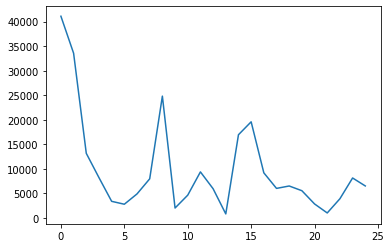

Epoch 1/25
8/8 - 3s - loss: 31037.1426 - accuracy: 0.4303 - auc_13: 0.5765 - precision_13: 0.4303 - recall_13: 0.4303 - f1_score: 0.2998 - val_loss: 12144.0352 - val_accuracy: 0.4672 - val_auc_13: 0.6139 - val_precision_13: 0.4672 - val_recall_13: 0.4672 - val_f1_score: 0.3138 - 3s/epoch - 362ms/step
Epoch 2/25
8/8 - 0s - loss: 18394.0684 - accuracy: 0.5205 - auc_13: 0.6478 - precision_13: 0.5205 - recall_13: 0.5205 - f1_score: 0.2595 - val_loss: 6398.3301 - val_accuracy: 0.5328 - val_auc_13: 0.6946 - val_precision_13: 0.5328 - val_recall_13: 0.5328 - val_f1_score: 0.3135 - 402ms/epoch - 50ms/step
Epoch 3/25
8/8 - 0s - loss: 5472.8501 - accuracy: 0.4508 - auc_13: 0.5972 - precision_13: 0.4508 - recall_13: 0.4508 - f1_score: 0.2667 - val_loss: 7940.2642 - val_accuracy: 0.3770 - val_auc_13: 0.5385 - val_precision_13: 0.3770 - val_recall_13: 0.3770 - val_f1_score: 0.2034 - 395ms/epoch - 49ms/step
Epoch 4/25
8/8 - 0s - loss: 8950.7549 - accuracy: 0.3934 - auc_13: 0.5518 - precision_13: 0.3

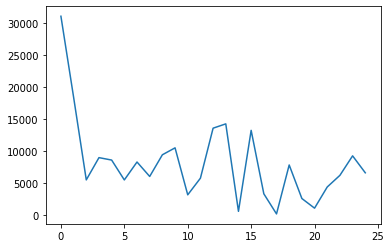

Epoch 1/25
8/8 - 3s - loss: 13436.4785 - accuracy: 0.4877 - auc_14: 0.6198 - precision_14: 0.4877 - recall_14: 0.4877 - f1_score: 0.3276 - val_loss: 65178.3477 - val_accuracy: 0.5902 - val_auc_14: 0.6926 - val_precision_14: 0.5902 - val_recall_14: 0.5902 - val_f1_score: 0.2474 - 3s/epoch - 345ms/step
Epoch 2/25
8/8 - 0s - loss: 11580.8477 - accuracy: 0.4672 - auc_14: 0.5991 - precision_14: 0.4672 - recall_14: 0.4672 - f1_score: 0.3110 - val_loss: 77386.8906 - val_accuracy: 0.4016 - val_auc_14: 0.5512 - val_precision_14: 0.4016 - val_recall_14: 0.4016 - val_f1_score: 0.1910 - 393ms/epoch - 49ms/step
Epoch 3/25
8/8 - 0s - loss: 18361.9863 - accuracy: 0.5082 - auc_14: 0.6385 - precision_14: 0.5082 - recall_14: 0.5082 - f1_score: 0.3387 - val_loss: 27540.4336 - val_accuracy: 0.5902 - val_auc_14: 0.6926 - val_precision_14: 0.5902 - val_recall_14: 0.5902 - val_f1_score: 0.2474 - 386ms/epoch - 48ms/step
Epoch 4/25
8/8 - 0s - loss: 13082.1670 - accuracy: 0.5451 - auc_14: 0.6584 - precision_14:

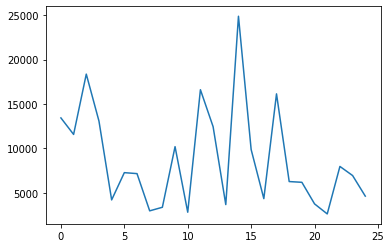

In [20]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [21]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
cnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 58.87% 
Balanced Accuracy: 24.77% 
ROC/AUC: 0.71 
Precision: 0.59 
Recall: 0.59 
F1 score: 0.25


### RCNN

Epoch 1/25
8/8 - 1s - loss: 1.4892 - accuracy: 0.2377 - auc_15: 0.4998 - precision_15: 0.2634 - recall_15: 0.2213 - f1_score: 0.2157 - val_loss: 1.7290 - val_accuracy: 0.0328 - val_auc_15: 0.3031 - val_precision_15: 0.5000 - val_recall_15: 0.0328 - val_f1_score: 0.0381 - 1s/epoch - 181ms/step
Epoch 2/25
8/8 - 0s - loss: 1.5180 - accuracy: 0.2377 - auc_15: 0.5432 - precision_15: 0.4472 - recall_15: 0.2254 - f1_score: 0.2221 - val_loss: 1.1923 - val_accuracy: 0.0574 - val_auc_15: 0.3514 - val_precision_15: 0.8750 - val_recall_15: 0.0574 - val_f1_score: 0.0639 - 285ms/epoch - 36ms/step
Epoch 3/25
8/8 - 0s - loss: 3.5795 - accuracy: 0.1844 - auc_15: 0.4883 - precision_15: 0.2113 - recall_15: 0.1844 - f1_score: 0.1830 - val_loss: 1.8930 - val_accuracy: 0.0164 - val_auc_15: 0.2734 - val_precision_15: 0.2500 - val_recall_15: 0.0164 - val_f1_score: 0.0196 - 235ms/epoch - 29ms/step
Epoch 4/25
8/8 - 0s - loss: 1.3378 - accuracy: 0.1025 - auc_15: 0.4020 - precision_15: 0.1289 - recall_15: 0.1025 

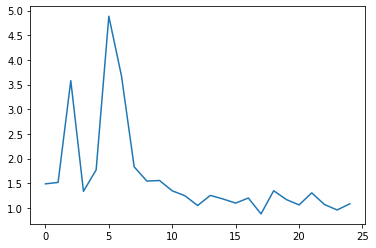

Epoch 1/25
8/8 - 2s - loss: 1.2091 - accuracy: 0.3852 - auc_16: 0.6986 - precision_16: 0.4372 - recall_16: 0.3279 - f1_score: 0.2674 - val_loss: 1.4115 - val_accuracy: 0.5984 - val_auc_16: 0.7887 - val_precision_16: 0.5000 - val_recall_16: 0.0164 - val_f1_score: 0.2496 - 2s/epoch - 246ms/step
Epoch 2/25
8/8 - 0s - loss: 0.8984 - accuracy: 0.5943 - auc_16: 0.7961 - precision_16: 0.6044 - recall_16: 0.4508 - f1_score: 0.3856 - val_loss: 1.4619 - val_accuracy: 0.3852 - val_auc_16: 0.6802 - val_precision_16: 0.5000 - val_recall_16: 0.0164 - val_f1_score: 0.1925 - 227ms/epoch - 28ms/step
Epoch 3/25
8/8 - 0s - loss: 0.8301 - accuracy: 0.4877 - auc_16: 0.7427 - precision_16: 0.4959 - recall_16: 0.2500 - f1_score: 0.2879 - val_loss: 1.5762 - val_accuracy: 0.3934 - val_auc_16: 0.6781 - val_precision_16: 0.5000 - val_recall_16: 0.0164 - val_f1_score: 0.2086 - 236ms/epoch - 29ms/step
Epoch 4/25
8/8 - 0s - loss: 1.1840 - accuracy: 0.5697 - auc_16: 0.7547 - precision_16: 0.6349 - recall_16: 0.1639 

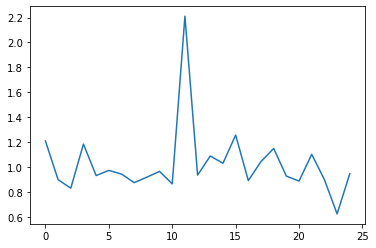

Epoch 1/25
8/8 - 1s - loss: 1.7434 - accuracy: 0.2500 - auc_17: 0.4867 - precision_17: 0.1735 - recall_17: 0.0697 - f1_score: 0.1996 - val_loss: 2.6965 - val_accuracy: 0.0328 - val_auc_17: 0.2530 - val_precision_17: 0.6000 - val_recall_17: 0.0246 - val_f1_score: 0.0316 - 1s/epoch - 179ms/step
Epoch 2/25
8/8 - 0s - loss: 1.2121 - accuracy: 0.2910 - auc_17: 0.4272 - precision_17: 0.2427 - recall_17: 0.1025 - f1_score: 0.2234 - val_loss: 1.2954 - val_accuracy: 0.4098 - val_auc_17: 0.4360 - val_precision_17: 0.6000 - val_recall_17: 0.0246 - val_f1_score: 0.2147 - 232ms/epoch - 29ms/step
Epoch 3/25
8/8 - 0s - loss: 3.9920 - accuracy: 0.4549 - auc_17: 0.6301 - precision_17: 0.5349 - recall_17: 0.0943 - f1_score: 0.2451 - val_loss: 1.9286 - val_accuracy: 0.3852 - val_auc_17: 0.6774 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_f1_score: 0.1888 - 235ms/epoch - 29ms/step
Epoch 4/25
8/8 - 0s - loss: 1.4240 - accuracy: 0.5410 - auc_17: 0.6892 - precision_17: 0.4839 - recall_17:

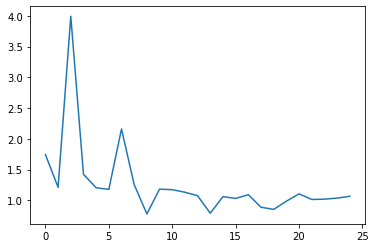

In [22]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [23]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
rnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 22.51% 
Balanced Accuracy: 34.43% 
ROC/AUC: 0.44 
Precision: 1.00 
Recall: 0.03 
F1 score: 0.13


## 4. Multimodal Late Fusion

### Dataset

In [24]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True, level=True, nopain=False)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 1, 350, 35) (366, 3)
(231, 1, 350, 35) (231, 3)


In [25]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', level=True, nopain=False)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 1, 350, 25) (366, 3)
(231, 1, 350, 25) (231, 3)


In [26]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### CNN + Bidirectional LSTM

In [27]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(64)(flatten_1)
        dense_1 = Dense(64, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(64)(flatten_2)
        dense_2 = Dense(64, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
8/8 - 4s - loss: 1.4023 - accuracy: 0.5246 - auc_18: 0.7402 - precision_18: 0.5000 - recall_18: 0.0041 - f1_score: 0.3355 - val_loss: 0.8853 - val_accuracy: 0.4918 - val_auc_18: 0.7517 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.2198 - 4s/epoch - 465ms/step
Epoch 2/25
8/8 - 0s - loss: 1.4584 - accuracy: 0.5902 - auc_18: 0.7897 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.2710 - val_loss: 0.8882 - val_accuracy: 0.4918 - val_auc_18: 0.7420 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.2198 - 396ms/epoch - 50ms/step
Epoch 3/25
8/8 - 0s - loss: 1.4590 - accuracy: 0.5902 - auc_18: 0.7913 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.2710 - val_loss: 0.8792 - val_accuracy: 0.4918 - val_auc_18: 0.7459 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.2198 - 392ms/epoch - 49ms/step
Epoch 4/25
8/8 - 0s - loss: 1.4609 - accuracy: 0.5902 - auc_18: 0.7876 - p

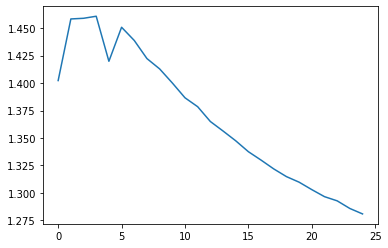

Epoch 1/25
8/8 - 4s - loss: 0.9324 - accuracy: 0.5574 - auc_19: 0.7754 - precision_19: 0.5700 - recall_19: 0.4672 - f1_score: 0.2386 - val_loss: 0.8327 - val_accuracy: 0.5984 - val_auc_19: 0.7906 - val_precision_19: 0.5965 - val_recall_19: 0.5574 - val_f1_score: 0.2496 - 4s/epoch - 515ms/step
Epoch 2/25
8/8 - 0s - loss: 0.9281 - accuracy: 0.5656 - auc_19: 0.7792 - precision_19: 0.5607 - recall_19: 0.5492 - f1_score: 0.2408 - val_loss: 0.8220 - val_accuracy: 0.5984 - val_auc_19: 0.7830 - val_precision_19: 0.5950 - val_recall_19: 0.5902 - val_f1_score: 0.2496 - 394ms/epoch - 49ms/step
Epoch 3/25
8/8 - 0s - loss: 0.9343 - accuracy: 0.5656 - auc_19: 0.7931 - precision_19: 0.5602 - recall_19: 0.5533 - f1_score: 0.2408 - val_loss: 0.8233 - val_accuracy: 0.5984 - val_auc_19: 0.7914 - val_precision_19: 0.5950 - val_recall_19: 0.5902 - val_f1_score: 0.2496 - 397ms/epoch - 50ms/step
Epoch 4/25
8/8 - 0s - loss: 0.9278 - accuracy: 0.5656 - auc_19: 0.7795 - precision_19: 0.5565 - recall_19: 0.5451 

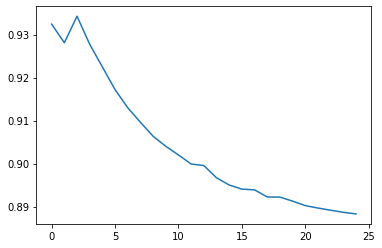

Epoch 1/25
8/8 - 4s - loss: 1.1729 - accuracy: 0.4098 - auc_20: 0.6854 - precision_20: 0.5000 - recall_20: 0.0328 - f1_score: 0.2148 - val_loss: 0.9757 - val_accuracy: 0.4016 - val_auc_20: 0.6866 - val_precision_20: 0.5000 - val_recall_20: 0.0082 - val_f1_score: 0.1910 - 4s/epoch - 470ms/step
Epoch 2/25
8/8 - 0s - loss: 1.1562 - accuracy: 0.4344 - auc_20: 0.7011 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.2173 - val_loss: 0.9890 - val_accuracy: 0.4016 - val_auc_20: 0.6907 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1910 - 401ms/epoch - 50ms/step
Epoch 3/25
8/8 - 0s - loss: 1.1493 - accuracy: 0.4344 - auc_20: 0.7176 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.2173 - val_loss: 0.9914 - val_accuracy: 0.4016 - val_auc_20: 0.6907 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1910 - 388ms/epoch - 49ms/step
Epoch 4/25
8/8 - 0s - loss: 1.1421 - accuracy: 0.4344 - auc_20: 0.7016 - precision

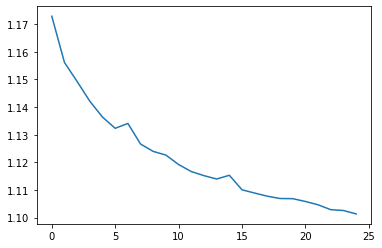

In [28]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [29]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
cnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 22.51% 
Balanced Accuracy: 34.43% 
ROC/AUC: 0.61 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.13


### RCNN

In [30]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(64)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(64)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
8/8 - 2s - loss: 4.2831 - accuracy: 0.3402 - auc_21: 0.5192 - precision_21: 0.3151 - recall_21: 0.2828 - f1_score: 0.2722 - val_loss: 23.8252 - val_accuracy: 0.1885 - val_auc_21: 0.3729 - val_precision_21: 0.1885 - val_recall_21: 0.1885 - val_f1_score: 0.1433 - 2s/epoch - 297ms/step
Epoch 2/25
8/8 - 0s - loss: 5.4805 - accuracy: 0.3893 - auc_21: 0.5790 - precision_21: 0.3932 - recall_21: 0.3770 - f1_score: 0.2926 - val_loss: 11.6389 - val_accuracy: 0.4590 - val_auc_21: 0.5943 - val_precision_21: 0.4590 - val_recall_21: 0.4590 - val_f1_score: 0.2097 - 361ms/epoch - 45ms/step
Epoch 3/25
8/8 - 0s - loss: 1.8439 - accuracy: 0.4180 - auc_21: 0.6443 - precision_21: 0.4145 - recall_21: 0.3975 - f1_score: 0.3341 - val_loss: 14.3811 - val_accuracy: 0.4918 - val_auc_21: 0.6104 - val_precision_21: 0.4918 - val_recall_21: 0.4918 - val_f1_score: 0.2539 - 354ms/epoch - 44ms/step
Epoch 4/25
8/8 - 0s - loss: 2.3798 - accuracy: 0.4385 - auc_21: 0.6382 - precision_21: 0.4388 - recall_21: 0.42

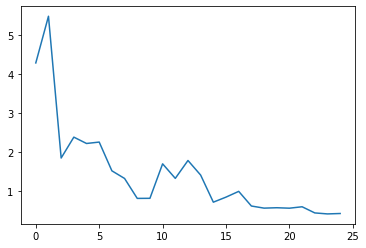

Epoch 1/25
8/8 - 2s - loss: 3.1068 - accuracy: 0.4344 - auc_22: 0.6701 - precision_22: 0.4336 - recall_22: 0.4016 - f1_score: 0.2990 - val_loss: 23.5810 - val_accuracy: 0.1557 - val_auc_22: 0.3468 - val_precision_22: 0.1557 - val_recall_22: 0.1557 - val_f1_score: 0.1389 - 2s/epoch - 228ms/step
Epoch 2/25
8/8 - 0s - loss: 0.9466 - accuracy: 0.3811 - auc_22: 0.6603 - precision_22: 0.3901 - recall_22: 0.3566 - f1_score: 0.2915 - val_loss: 26.8734 - val_accuracy: 0.0492 - val_auc_22: 0.2772 - val_precision_22: 0.0492 - val_recall_22: 0.0492 - val_f1_score: 0.0508 - 355ms/epoch - 44ms/step
Epoch 3/25
8/8 - 0s - loss: 2.9820 - accuracy: 0.5820 - auc_22: 0.7932 - precision_22: 0.5787 - recall_22: 0.5574 - f1_score: 0.3903 - val_loss: 16.5091 - val_accuracy: 0.1148 - val_auc_22: 0.3148 - val_precision_22: 0.1148 - val_recall_22: 0.1148 - val_f1_score: 0.1005 - 408ms/epoch - 51ms/step
Epoch 4/25
8/8 - 0s - loss: 1.2815 - accuracy: 0.5451 - auc_22: 0.7318 - precision_22: 0.5473 - recall_22: 0.54

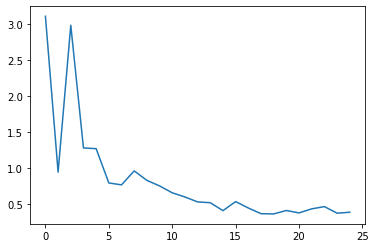

Epoch 1/25
8/8 - 2s - loss: 2.3584 - accuracy: 0.3238 - auc_23: 0.5040 - precision_23: 0.3302 - recall_23: 0.2910 - f1_score: 0.2674 - val_loss: 35.4192 - val_accuracy: 0.4098 - val_auc_23: 0.5574 - val_precision_23: 0.4098 - val_recall_23: 0.4098 - val_f1_score: 0.2147 - 2s/epoch - 227ms/step
Epoch 2/25
8/8 - 0s - loss: 2.7776 - accuracy: 0.4959 - auc_23: 0.7147 - precision_23: 0.5000 - recall_23: 0.4959 - f1_score: 0.3351 - val_loss: 13.9651 - val_accuracy: 0.5820 - val_auc_23: 0.6865 - val_precision_23: 0.5820 - val_recall_23: 0.5820 - val_f1_score: 0.2681 - 355ms/epoch - 44ms/step
Epoch 3/25
8/8 - 0s - loss: 1.6504 - accuracy: 0.5164 - auc_23: 0.7382 - precision_23: 0.5274 - recall_23: 0.5123 - f1_score: 0.3453 - val_loss: 16.2267 - val_accuracy: 0.4098 - val_auc_23: 0.5574 - val_precision_23: 0.4098 - val_recall_23: 0.4098 - val_f1_score: 0.2147 - 362ms/epoch - 45ms/step
Epoch 4/25
8/8 - 0s - loss: 1.8105 - accuracy: 0.4672 - auc_23: 0.6490 - precision_23: 0.4625 - recall_23: 0.45

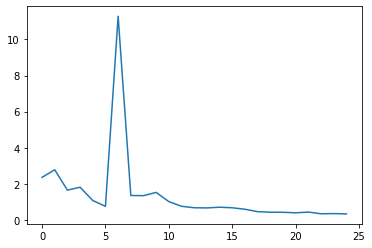

In [31]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [32]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
rnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 52.81% 
Balanced Accuracy: 35.78% 
ROC/AUC: 0.77 
Precision: 0.53 
Recall: 0.53 
F1 score: 0.32


### Ensemble

In [33]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return self.bestscore

In [34]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [35]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [36]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.0011)
RCNN Body Model (weight: 0.3136)
CNN + Bidirectional LSTM Face Model (weight: 0.0005)
RCNN Face Model (weight: 0.6847)
Accuracy: 63.64% - ROC/AUC: 0.66 - Precision: 0.40 - Recall: 0.50 - F1 score: 0.35


## Results

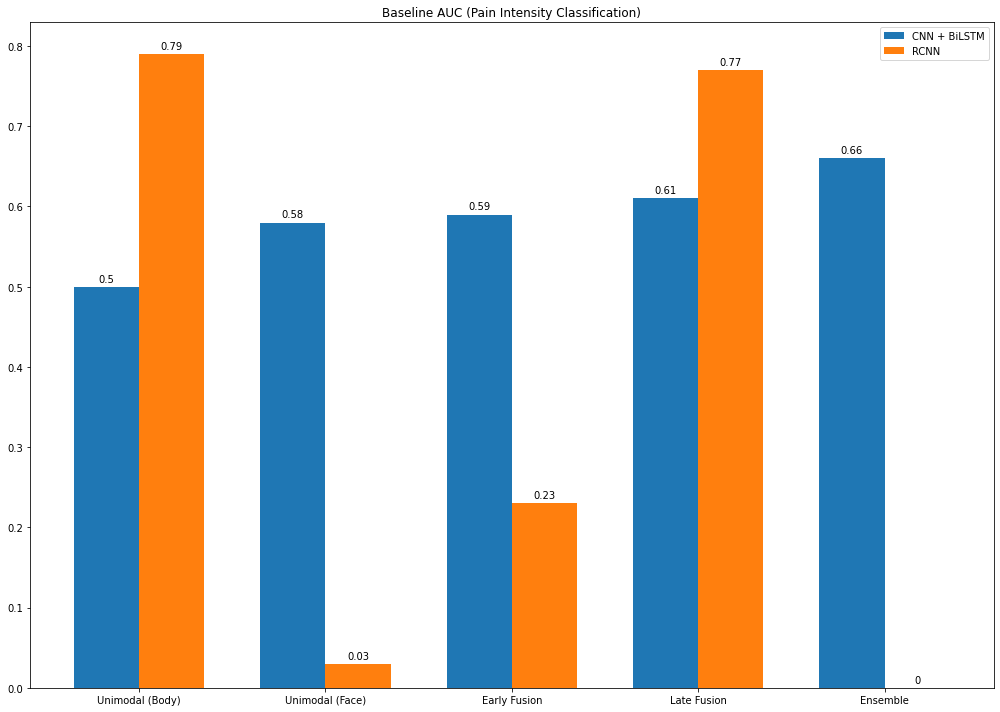

In [37]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']
men_means = cnn_auc
women_means = rnn_auc

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, men_means, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, women_means, width, label='RCNN')

ax.set_title('Baseline AUC (Pain Intensity Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()